# Creating a Baseline Tag Labeler

Here we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html) and [scikit-learn](https://scikit-learn.org/stable/) to create a baseline multi-class, multi-label classifier that will label our sample of [Stack Overflow](http://stackoverflow.com) posts (questions and their answers), two thirds of which lack labels. This will serve as a basis of comparison for the deep network we will train therafter. We will create separate [embeddings](https://keras.io/layers/embeddings/) of their language and code and use these as the signal for our model.

In [1]:
import cupy as cp
import json
import numpy as np
import pandas as pd
import re

print("I'm working!")

I'm working!


#### Load our sample of questions/answers with at least 1 vote and 1 answer

In [2]:
sorted_all_tags = json.load(open('data/stackoverflow/08-05-2019/sorted_all_tags.50000.json'))
max_index = sorted_all_tags[-1][0] + 1

In [3]:
import pyarrow
posts_df = pd.read_parquet(
    'data/stackoverflow/08-05-2019/Questions.Stratified.Final.50000.parquet',
    columns=['_Body'] + ['label_{}'.format(i) for i in range(0, max_index)],
    engine='pyarrow'
)
posts_df.head(5)

,_Body,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_14,label_15,label_16,label_17,label_18,label_19,label_20,label_21,label_22,label_23
0,"[C, Mono, Winforms, MessageBox, problem, I, fi...",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Are, NET, data, providers, Oracle, require, O...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[How, I, focus, foreign, window, I, applicatio...",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[Default, button, hit, windows, forms, trying,...",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[Can, I, avoid, JIT, net, Say, code, always, g...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(
    '{:,} answered questions with at least 1 upvote'.format(len(posts_df.index))
)

1,293,018 answered questions with at least 1 upvote


## Map from Tags to IDs

In [5]:
tag_index = json.load(open('data/stackoverflow/08-05-2019/tag_index.50000.json'))
index_tag = json.load(open('data/stackoverflow/08-05-2019/index_tag.50000.json'))

## Count the Most Common Tags

In [6]:
label_counts = json.load(open('data/stackoverflow/08-05-2019/label_counts.50000.json'))

# Sanity check the difference files
assert(len(label_counts.keys()) == len(tag_index.keys()) == len(index_tag.keys()) == len(sorted_all_tags))

## To Be Consistent: Make Record Count a Multiple of the Batch Size and Post Sequence Length

Although it is not necessary in our baseline labeler, the Elmo embedding in the network model requires that the number of records be a multiple of the batch size times the number of tokens in the padded posts. We do the same thing to keep the data consistent.

In [7]:
import math

BATCH_SIZE = 32
MAX_LEN = 100
EMBED_SIZE = 50

# Convert label columns to numpy array
labels = posts_df[list(posts_df.columns)[1:]].to_numpy()

# training_count must be a multiple of the BATCH_SIZE times the MAX_LEN for the Elmo embedding layer
highest_factor = math.floor(len(posts_df.index) / (BATCH_SIZE * MAX_LEN))
training_count = highest_factor * BATCH_SIZE * MAX_LEN
print('Highest Factor: {:,} Training Count: {:,}'.format(highest_factor, training_count))

# Remove stopwords - now done in Spark, so can remove once that runs
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

documents = []
for body in posts_df[0:training_count]['_Body'].values.tolist():
    words = body.tolist()
    documents.append(words)

labels = labels[0:training_count]

# Lengths for x and y match
assert( len(documents) == training_count == labels.shape[0])

Highest Factor: 404 Training Count: 1,292,800


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Sample the data to speed development

In [8]:
# import random
# random.seed(33)

# SAMPLE_SIZE = 10000
# id_list = list(range(0, len(filtered_code_words)))
# idx = random.sample(id_list, SAMPLE_SIZE)

# # idx = np.random.choice(np.arange(len(matrix_posts)), SAMPLE_SIZE, replace=False)

# sampled_posts = [x for i, x in enumerate(filtered_code_words) if i in idx]
# sampled_labels = [x for i, x in enumerate(new_labels) if i in idx]

# del filtered_code_words
# del new_labels

# len(sampled_posts), len(sampled_labels)

#### REMINDER: When we add text words we must combine the two valid label lists and then create a new list of labels

In [9]:
# MIN_TEXT = 20

# def extract_text(x):
#     doc = BeautifulSoup(x)
#     codes = doc.find_all('code')
#     [code.extract() if code else None for code in codes]
#     return doc.text

# post_text = tag_posts._Body.apply(extract_text)
# post_text_words = [x.split() for x in post_text.tolist()]

# # Take words with > MIN_TEXT (20) instances
# post_text_words = [[y for y in x if tag_counts[y] > MIN_TEXT] for x in post_text_words]

# # Create a new list of labels to match the new non-empty lists of words
# text_post_ids = defaultdict(bool)
# text_post_id_list = []
# for i, post in enumerate(post_text_words):
#     if len(post) == 0:
#         pass
#     else:
#         text_post_ids[i] = True
#         text_post_id_list.append(i)

#### Encode the tags, replacing their string form with their respective IDs

In [10]:
# encoded_tags = []
# raw_tags = []
# for tagset in coded_tags:
#    encoded_tags.append([1 if id in tagset else 0 for id in id_to_tag.keys()])

# labels = np.array(encoded_tags)

# encoded_tags[0]

## Create a Baseline Gradient Boosted Decision Tree Model

It is useful to have a decision tree model to use as a baseline for comparison with our deep network model. XGBoost's implementation of gradient boosted decision trees is state of the art for this kind of application, but it can't do multi-class, multi-label classification. Therefore we use an [`xgboost.XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) with an [`sklearn.multiclass.OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) on top of the XGBoost classifier to train one classifier model per label and then apply them to each label to compute the output for each.

We define `VOCAB_SIZE`, `MAX_LENGTH` and `TEST_SPLIT` to define the number of unique words as input into our embedding, the sequence length for each input, and the test/train split for our performance testing.

#### Encode the data using Gensim and Word2Vec

For the network, we'll create our own embeddings. For the baseline model we'll use Word2Vec.

In [11]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

from gensim.sklearn_api import W2VTransformer
from gensim.models import Word2Vec

import xgboost as xgb

VOCAB_SIZE = 5000
MAX_LENGTH = 100
EMBEDDING_SIZE = 50
NUM_CORES = 64

TEST_SPLIT = 0.2

from os import path

w2v_model  = None
model_path = "data/stackoverflow/08-05-2019/word2vec.50000.model"

# Load the Word2Vec model if it exists
if path.exists(model_path):
        w2v_model = Word2Vec.load(model_path)
else:
    w2v_model = Word2Vec(
        documents,
        size=EMBEDDING_SIZE,
        min_count=1,
        window=10,
        workers=NUM_CORES,
        iter=10,
        seed=33
    )
    w2v_model.save(model_path)

print('Word2Vec model built!')

Word2Vec model built!


In [12]:
w2v_model.wv.most_similar(positive='program')

[('program,', 0.8181056380271912),
 ('programme', 0.79691481590271),
 ('programm', 0.7924904227256775),
 ('script', 0.7402550578117371),
 ('process', 0.7230151891708374),
 ('programs', 0.701980471611023),
 ('shellcode', 0.6727394461631775),
 ('routine', 0.6723151803016663),
 ('computer', 0.6718624830245972),
 ('code', 0.6691910624504089)]

In [13]:
encoded_docs = [[w2v_model.wv[word] for word in post] for post in documents]
len(encoded_docs)

1292800

In [14]:
len(encoded_docs), len(encoded_docs[0]), encoded_docs[0][0]

(1292800,
 100,
 array([-2.9409578e+00, -4.1849041e+00,  6.7010484e+00, -1.4716268e+00,
         2.9712517e+00, -6.3206053e-01, -9.0127773e+00,  3.0089478e+00,
         1.1931713e+00,  1.8483908e-01, -6.7743816e+00, -9.2341967e+00,
        -7.9219651e+00,  2.6767936e+00, -2.4017296e+00,  7.1178694e+00,
        -1.5009764e+00, -2.3618896e+00,  6.7281699e+00,  3.6489727e+00,
         8.0505657e+00, -3.6835766e+00,  2.3223200e+00,  6.0346580e+00,
         5.9107943e+00,  6.0556936e+00, -4.1783504e+00, -1.9313576e+00,
         3.8984590e+00,  7.8368597e+00, -7.7179809e+00, -1.6969135e+00,
        -4.9251043e-03,  3.1653295e+00, -3.6848946e+00,  1.1325817e+00,
         3.0500324e+00,  4.1951466e+00,  9.9863559e-01,  4.7049537e+00,
         6.3241501e+00,  8.2160950e+00, -9.7910541e-01,  9.6309919e+00,
         1.7616647e+00,  3.3550117e+00, -2.2989798e+00,  9.2685914e-01,
        -4.4009628e+00,  3.3147459e+00], dtype=float32))

### Pad and limit the posts to MAX_LENGTH (100) words using the average of all words in the corpus

We will now compute a position-wise maximum and minimum, concatenate these values, and use them to pad any documents with less than 20 words. We will simultaneously truncate any documents with more than 20 words. If we were creating our own embeddings using keras we would use [`keras.preprocessing.pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences), but using [`gensim.models.word2vec`](https://radimrehurek.com/gensim/models/word2vec.html) we pad them on our own.

See [Representation learning for very short texts using weighted word embedding aggregation](https://arxiv.org/pdf/1607.00570.pdf) referenced from [Stack Overflow](https://datascience.stackexchange.com/a/17348/59975).

In [15]:
from math import ceil

padded_posts = []
for post in encoded_docs:
    # Pad short posts with alternating min/max
    if len(post) < MAX_LENGTH:
        pointwise_min = np.minimum.reduce(post)
        pointwise_max = np.maximum.reduce(post)
        padding = [pointwise_max, pointwise_min]
        
        post += padding * ceil((MAX_LENGTH - len(post) / 2.0))
        
    # Shorten long posts or those odd number length posts we padded to 51
    if len(post) > MAX_LENGTH:
        post = post[:MAX_LENGTH]
      
    padded_posts.append(post)

# Verify their lengths
assert(min([len(post) for post in padded_posts]) == MAX_LENGTH)
assert(max([len(post) for post in padded_posts]) == MAX_LENGTH)

# Free up the RAM, since we copied the data
# del encoded_docs
len(padded_posts), len(padded_posts[0]), padded_posts[0][0]

(1292800,
 100,
 array([-2.9409578e+00, -4.1849041e+00,  6.7010484e+00, -1.4716268e+00,
         2.9712517e+00, -6.3206053e-01, -9.0127773e+00,  3.0089478e+00,
         1.1931713e+00,  1.8483908e-01, -6.7743816e+00, -9.2341967e+00,
        -7.9219651e+00,  2.6767936e+00, -2.4017296e+00,  7.1178694e+00,
        -1.5009764e+00, -2.3618896e+00,  6.7281699e+00,  3.6489727e+00,
         8.0505657e+00, -3.6835766e+00,  2.3223200e+00,  6.0346580e+00,
         5.9107943e+00,  6.0556936e+00, -4.1783504e+00, -1.9313576e+00,
         3.8984590e+00,  7.8368597e+00, -7.7179809e+00, -1.6969135e+00,
        -4.9251043e-03,  3.1653295e+00, -3.6848946e+00,  1.1325817e+00,
         3.0500324e+00,  4.1951466e+00,  9.9863559e-01,  4.7049537e+00,
         6.3241501e+00,  8.2160950e+00, -9.7910541e-01,  9.6309919e+00,
         1.7616647e+00,  3.3550117e+00, -2.2989798e+00,  9.2685914e-01,
        -4.4009628e+00,  3.3147459e+00], dtype=float32))

#### Convert the 3D feature array into a wider 2D array

The classifier requires 2D data, so we need to convert our 3D feature array into a wider 2D feature array. We will do this by iterating through the 50 padded elements of Word2Vec vectors for each post and appending them to a long list for each post.

Note that the type of `padded_posts` is `list(list(np.array))`, an artifact of the Word2Vec mapping.

#### Create one Row per Label Column

Training a `sklearn.multiclass.OneVsRestClassifier` with one `xgboost.XGBClassifier` per label exceeded 64GB of RAM and so we are remapping the data to have one instance of the row for each label column in a given row.

For example:

```python
# Input
rows, labels = [0.1, 0.3, 0.4, ...],[0,1,0,1]

# Output
rows_w_labels = [
    ([0.1, 0.3, 0.4, ...], 0),
    ([0.1, 0.3, 0.4, ...], 1),
    ([0.1, 0.3, 0.4, ...], 0),
    ([0.1, 0.3, 0.4, ...], 1)
]
```

#### GPU and CPU RAM Requirements

The configuration I use assumes 8GB of GPU RAM and 64GB of CPU RAM. If you have less GPU RAM, lower the `ITERATOR_MULTIPLE`. If you have less CPU RAM, reduce the number of records.

In [32]:
import cupy as cp
import sys

# cupy memory management
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

ITERATOR_MULTIPLE = 25
row_length = MAX_LENGTH * EMBEDDING_SIZE

matrix_posts = []
flat_labels = []
print_shape = False
print_dot = True

print(f'{len(padded_posts):,} padded_posts, {labels.shape} labels')

cpu_posts = []
five_k_count = 0
for i, post in enumerate(padded_posts):
    # Starting with an empty array and append the entire list of embedded words to it, 
    # expanding it's shape to (5000,)
    post = cp.array(post)
    if print_shape and i % 5000 == 0:
        print('post.shape', post.shape)
    
    post_row = cp.concatenate(post, axis=0)
    if print_shape and i % 5000 == 0:
        print('post_row.shape', post_row.shape)
    
    assert(post_row.shape == (row_length,))
    
    # Now add a downward dimension to the data, expanding its dimensions to (1,5000)
    post_row = cp.expand_dims(post_row, axis=0)
    if print_shape and i % 5000 == 0:
        print('post_row.shape', post_row.shape)
    
    assert(post_row.shape == (1,row_length))
    
    if print_shape and i % 5000 == 0:
        print(len(post_row[0]))
    
    matrix_posts.append(post_row)
    
    if print_dot and i % 5000 == 0:
        sys.stderr.write('.')
    
    # Every 25 * 5000 rows, send GPU RAM to main RAM or it will crash with 7618GB cards (g3.4xlarge)
    if i % 5000 == 0:
        five_k_count += 1
        first_five_k = True
        
    if five_k_count % ITERATOR_MULTIPLE == 0 and first_five_k is True:
        print(f'\ni:{i:,} 5k:{five_k_count:,} GPU RAM --> CPU RAM')
        cpu_posts.append(
            cp.asnumpy(cp.concatenate(matrix_posts, axis=0))
        )
        del matrix_posts
        matrix_posts = []
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
        print('Completed!')
        
        first_five_k = False

# Do the final concat for the remainder over 5K and clear GPU RAM
cpu_posts.append(
    cp.asnumpy(cp.concatenate(matrix_posts, axis=0))
)
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

# Memory conservation is critical
# del padded_posts
del matrix_posts
len(cpu_posts)

1,292,800 padded_posts, (1292800, 24) labels


.........................


i:120,000 5k:25 GPU RAM --> CPU RAM
Completed!


.........................


i:245,000 5k:50 GPU RAM --> CPU RAM
Completed!


.........................


i:370,000 5k:75 GPU RAM --> CPU RAM
Completed!


.........................


i:495,000 5k:100 GPU RAM --> CPU RAM
Completed!


.........................


i:620,000 5k:125 GPU RAM --> CPU RAM
Completed!


.........................


i:745,000 5k:150 GPU RAM --> CPU RAM
Completed!


.........................


i:870,000 5k:175 GPU RAM --> CPU RAM
Completed!


.........................


i:995,000 5k:200 GPU RAM --> CPU RAM
Completed!


.........................


i:1,120,000 5k:225 GPU RAM --> CPU RAM
Completed!


.........................


i:1,245,000 5k:250 GPU RAM --> CPU RAM
Completed!


.........

11

In [33]:
np_cpu_posts = np.concatenate(cpu_posts, axis=0)

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

del cpu_posts
cpu_posts = np_cpu_posts

cpu_posts.shape

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

(1292800, 5000)

In [34]:
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

#### Sample the Data Once Again

In [ ]:
# SAMPLE_SIZE = 1000
# id_list = list(range(0, len(matrix_posts)))
# idx = random.sample(id_list, SAMPLE_SIZE)
# sampled_posts = [post for i, post in enumerate(matrix_posts) if i in idx]
# sampled_labels = [label for i, label in enumerate(flat_labels) if i in idx]

# del matrix_posts
# del flat_labels
# len(sampled_posts), len(sampled_labels)

#### Convert from GPU `cupy.ndarray` to main memory `numpy.ndarray`

### Train the Baseline Model

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    cpu_posts,
    labels,
    test_size=TEST_SPLIT,
    random_state=1337
)
# del matrix_posts
# del labels

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

(1034240, 5000) (258560, 5000) (1034240, 24) (258560, 24)
float32 float32 int64 int64


## Compute Sample Weights

In [37]:
from sklearn.utils.class_weight import compute_sample_weight

train_sample_weights = compute_sample_weight('balanced', y_train).tolist()
test_sample_weights = compute_sample_weight('balanced', y_test).tolist()

train_sample_weights, test_sample_weights

([0.0001318841169496333,
  1.3037444443670205e-07,
  7.764130177354329e-05,
  7.561055902617928e-06,
  0.00011403844703654711,
  4.4243636117116125e-06,
  1.3037444443670205e-07,
  3.458236441128177e-06,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  0.004008547885223326,
  0.0013583527650081573,
  1.3037444443670205e-07,
  1.7905655990743493e-06,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  4.749549830646288e-05,
  1.3037444443670205e-07,
  0.0034087941941906307,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  0.00011394578379118706,
  1.3037444443670205e-07,
  4.342324842862687e-06,
  1.3037444443670205e-07,
  6.553068698770969e-06,
  0.06785761598738561,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  2.121211325429623e-06,
  0.00014147245852330704,
  2.9847570194472e-06,
  4.062494283266732e-06,
  5.510694267198438e-06,
  1.3037444443670205e-07,
  1.3037444443670205e-07,
  0.00010491673421662921,
  1.30

In [38]:
len(train_sample_weights), len(test_sample_weights)

(1034240, 258560)

## Compute Class Weights

In [39]:
train_weight_vec = list(np.max(np.sum(y_train, axis=0))/np.sum(y_train, axis=0))
train_class_weights = {i: train_weight_vec[i] for i in range(y_train.shape[1])}

test_weight_vec = list(np.max(np.sum(y_test, axis=0))/np.sum(y_test, axis=0))
test_class_weights = {i: test_weight_vec[i] for i in range(y_test.shape[1])}

# sorted(list(train_class_weights.items()), key=lambda x: x[1]), sorted(list(test_class_weights.items()), key=lambda x: x[1])
train_class_weights

{0: 3.064303488016763,
 1: 2.371098500202675,
 2: 2.6609803252587287,
 3: 3.0691268418521274,
 4: 3.4792565055762084,
 5: 1.1721270413786193,
 6: 2.6288903037339426,
 7: 2.1467368034742185,
 8: 2.0044547245780864,
 9: 2.00892933802696,
 10: 1.868153510406132,
 11: 2.328390884665141,
 12: 1.360032550569635,
 13: 2.190823970037453,
 14: 2.2936966964023133,
 15: 2.936618834455926,
 16: 1.0,
 17: 1.621670324592815,
 18: 3.2634711051187875,
 19: 4.003992926815355,
 20: 1.869994938327517,
 21: 2.653536460892904,
 22: 2.1827171242886907,
 23: 2.431382057499134}

In [40]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight(
#     'balanced',
#      np.unique(y_train.tolist()),
#      y_train.tolist()
# )
y_train.shape

(1034240, 24)

## Load the model if available otherwise create and fit the model

In [ ]:
import os, pickle
from sklearn.ensemble import RandomForestClassifier

MODEL_PATH = 'data/RandomForest.model'
if os.path.exists(MODEL_PATH):
    print(f'Found existing model in \'{MODEL_PATH}\'. Loading...')
    clf = pickle.load(open(MODEL_PATH, 'rb'))
    print('Successfully loaded model!')
else:
    print(f'No model found at \'{MODEL_PATH}\'. Initializing...')
    clf = RandomForestClassifier(
        n_estimators=100,
        n_jobs=NUM_CORES,
        class_weight='balanced',
        random_state=1337,
        verbose=1,
    )
    print('Model initialized. Fitting...')
    clf.fit(X_train, y_train)#, sample_weight=train_sample_weights)
    print('Model fitted. Saving to \'{MODEL_PATH}\'...')
    with open('data/RandomForest.model', 'wb') as f:
        pickle.dump(clf, f)
    print('Model saved!')

clf

## Take a sub-sample for initial training

In [41]:
X_train_sample = X_train[:100000]
X_test_sample  = X_test[:10000]
y_train_sample = y_train[:100000]
y_test_sample  = y_test[:10000]

X_train_sample.shape, X_test_sample.shape, y_train_sample.shape, y_test_sample.shape

((100000, 5000), (10000, 5000), (100000, 24), (10000, 24))

## Tune the random forests' hyperparameters

In [ ]:
# From https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# How to weight the classes
class_weights = ['balanced', None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weights}

clf = RandomForestClassifier(
    verbose=2,
)

rf_random = RandomizedSearchCV(
    estimator=clf,
    param_distributions=random_grid,
    scoring=['f1_micro', 'precision_micro', 'recall_micro', 'jaccard_micro',],
    refit='f1_micro',
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=1337,
    n_jobs=-1
)
rf_random.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


In [ ]:
print(rf_random.cv_results_)
print(rf_random.best_score_)
print(rf_random.best_params_)
print(rf_random.best_index_)
print(rf_random.refit_time_)

## Create binary and probability prediction scores for the test data

We then compare the numbers of predictions per class for the expected and actual predictions

In [ ]:
# tag_labels = [tag[1] for tag in sorted_all_tags]

# y_pred = clf.predict(X_test)
# y_pred_prob = clf.predict_proba(X_test)

# # Sanity check the raw / ratios of counts predictions in each column
# y_test.sum(axis=0), y_pred.sum(axis=0), \
# (y_test.sum(axis=0) / y_test.shape[0]), \
# (y_pred.sum(axis=0) / y_pred.shape[0]), \
# (y_test.sum(axis=0) / y_test.shape[0]) - (y_pred.sum(axis=0) / y_pred.shape[0])

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape, len(train_sample_weights), len(test_sample_weights)

<div>
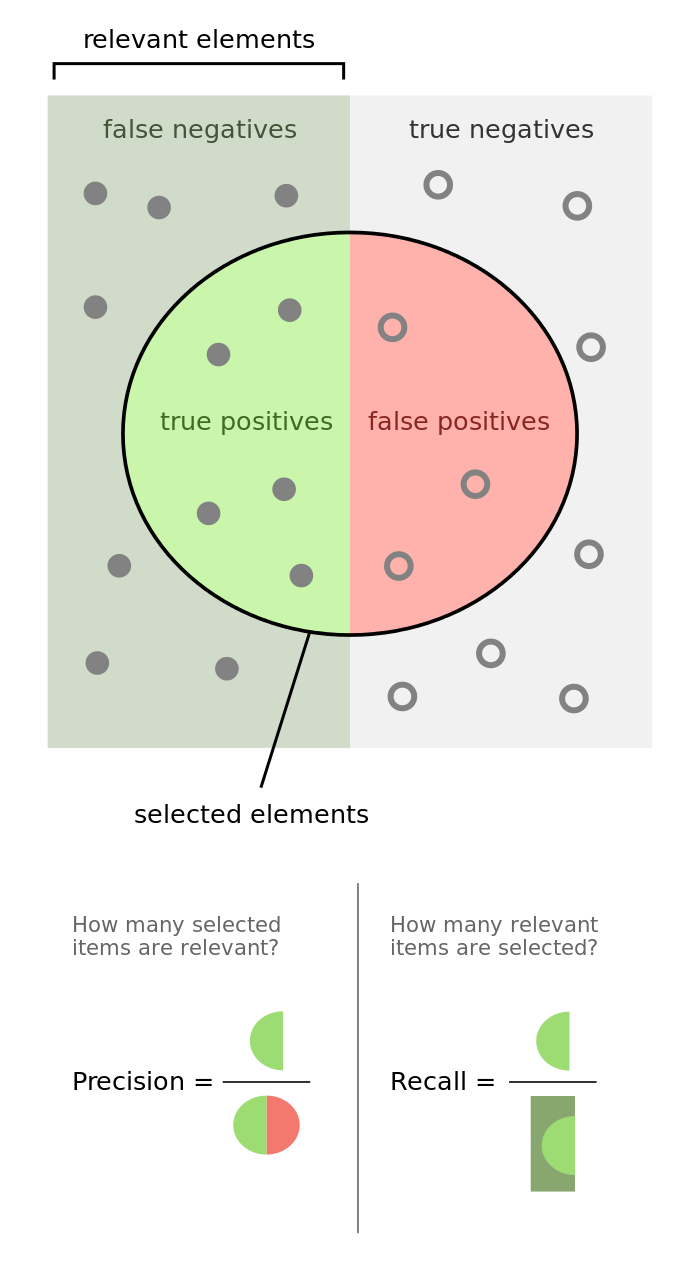
</div>

In [ ]:
# yes_cols = []
# for col in y_pred_prob:
#     yes_cols.append(col[:,1].tolist())

# y_score = np.array(yes_cols).T
# n_classes = y_test.shape[1]

# MIN_THRESH = 0.0
# MAX_THRESH = 0.1
# NUM_STEPS = 20
# AVERAGE = 'micro'
# for threshold in np.linspace(MIN_THRESH, MAX_THRESH, NUM_STEPS + 1):
#     y_pred = y_score < threshold
#     print(
#         '{:.4f} {:.4f} {:.4f}'.format(
#             threshold, 
#             precision_score(y_pred, y_test, average=AVERAGE),
#             recall_score(y_pred, y_test, average=AVERAGE),
#         )
#     )

## Check a variety of performance metrics

Check both with and without test sample weights...

In [ ]:
# import inspect
# from sklearn.metrics import recall_score, precision_score, f1_score, jaccard_score, hamming_loss

# metric_scores = []

# for metric in (recall_score, precision_score, f1_score, jaccard_score, hamming_loss):
    
#     args = {}
#     if metric.__name__ in [ f1_score.__name__, 
#                             recall_score.__name__, 
#                             precision_score.__name__,
#                             jaccard_score.__name__]:
#         args['average'] = 'weighted'
    
#     # if 'sample_weight' in inspect.getargspec(metric).args:
    
#     for threshold in range(0.03

#     y_score < threshold
        
#     # Try with sample weights and y_pred
#     metric_scores.append((
#         str(metric),
#         'binary',
#         # str(test_sample_weights),
#         metric(
#             y_test, 
#             y_pred,
#             # sample_weight=test_sample_weights,
#             **args
#         )
#     ))
        
# #         # Try with sample weights and y_pred_prob
# #         metric_scores.append(
# #             str(metric),
# #             'probability',
# #             str(test_sample_weights),
# #             metric(
# #                 y_test, 
# #                 y_pred_prob,
# #                 sample_weight=test_sample_weights
# #             )
# #         )
    
#     # Try without sample weights and y_pred
# #     metric_scores.append((
# #         str(metric),
# #         'binary',
# #         str(None),
# #         metric(
# #             y_test, 
# #             y_pred,
# #             **args
# #         )
# #     ))
    
# #     # Try without sample weights and y_pred_prob
# #     metric_scores.append(
# #         str(metric),
# #         'probability',
# #         str(None),
# #         metric(
# #             y_test, 
# #             y_pred_prob,
# #         )
# #     )
    

# metric_scores

In [ ]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# ravel_ratio = int(y_test.ravel().shape[0] / y_test.shape[0])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# for t, tp, fp in zip(thresholds, tpr["micro"], fpr["micro"]):
#     print(t, tp, fp)
    

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# lw = 2
# plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# # Compute macro-average ROC curve and ROC area
# from scipy import interp
# from itertools import cycle

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(10,10))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()